<a href="https://colab.research.google.com/github/seungmindavid/Representational_Learning/blob/main/cVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Conditionalization
a) Derive the standard $\log(p(x)$ bound (the ELBO) loss function, but for the conditional model in figure b, i.e. derive the same bound for $\log p(x|c)$

- Original (without c) $\log p(x)$ bound:
$L(p(x|z), q(z|x)) = \mathbb{E}_{q(z|x)}[MSE(x, p(x|z))]+KL[q(z|x) || N(0,I)]$

$\longrightarrow -\log p(x) = -\log p(x|z) + KL[q(z|x) || N(0,I)]$, where
$KL[q(z|x) || N(0,I)] = 0.5(-\log \frac{\Sigma_p}{\Sigma_q} -k + tr\Sigma^{-1}_p \Sigma_q + (\mu_2 - \mu_1)^T\Sigma^{-1}_p(\mu_2-\mu_1))$

Then, $L(p(x|c,z), q(z|x)) = -\log p(x|c,z) + KL[q(z|x) || N(0,I)]$.

And $\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

$= -\log p(x|c,z) + 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)$

b) Implement this conditional model in PTorch. Using the MNIST dataset, train your model with the digit label as the c condition. I used k=2.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
import pathlib

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


# Loading Dataset (MNIST)

Batch size for training dataset: 1024
Batch size for test dataset: 10


In [2]:
batch_size_train = 1024
batch_size_test = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download = True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size= batch_size_test, shuffle=False
)


100%|██████████| 9912422/9912422 [00:00<00:00, 102639604.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98886280.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56824572.30it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21796943.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction (EBLO)

$\log p(x) \geq \log p(x|z) - KL[q(z|x)||p(x)]$

And we want minimal loss (convert $+ \rightarrow -$)


$L = -\log p(x) = \log p(x|c,z) + KL[q(z|x)||p(x)]$

$-\log p(x|c,z)$ : MSE is built in Pytorch

$\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

In [3]:
def KL_div_N01(z_mu, z_log_sigma_sq):
  term_1 = z_log_sigma_sq.sum(axis=1) # trace log Sigma q
  term_2 = z_log_sigma_sq.exp().sum(axis=1) # trace Sigma q
  term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
  return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

In [4]:
def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

# Build VAE(Without using c-label values): Using class material

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 2 neurons -> 512 neurons -> 784 neurons

In [5]:

##
## fully connected
##
class VAE( nn.Module ):
    def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
        super(VAE, self).__init__()

        self.enc = nn.ModuleList()
        self.dec = nn.ModuleList()
        self.n_z = n_z

        for i in range(n_layers+1):
            if i == 0: #first layers
                self.enc.append(nn.Linear(n_input, layer_size))
                self.dec.append(nn.Linear(n_z, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())
            elif i == n_layers: #last layers
                self.enc.append(nn.Linear(layer_size, 2*n_z)) # we need this for enc's mu and sigma
                self.dec.append(nn.Linear(layer_size, n_output))
            else:
                self.enc.append(nn.Linear(layer_size, layer_size))
                self.dec.append(nn.Linear(layer_size, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())

        self.enc = nn.Sequential(*self.enc)
        self.dec = nn.Sequential(*self.dec)


    def enc_to_mean_lss(self,x):
        enc_output = self.enc(x)
        mean = enc_output[...,:self.n_z]
        log_sigma_sq = enc_output[...,self.n_z:]
        return mean, log_sigma_sq

    def forward(self, x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)

        sigma = log_sigma_sq.exp().sqrt()
        z = mean + torch.randn_like(mean)*sigma
        output = self.dec(z)

        return output

    def forward_train(self, x):

        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        #print(mean.shape)
        z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
        output = self.dec(z)

        return output, mean, log_sigma_sq

    def encode_mean(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        return mean

    def encode(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        sigma = self.enc_log_sigma_sq.exp().sqrt()
        return mean + torch.randn_like(mean)*sigma

    def decode(self,z):
        return self.dec(z)



# Build cVAE in Pytorch (VAE with c-label values)

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$,
$c^{(i)} \in \mathbb{R} \rightarrow c^{(i)} \in \mathbb{R}^{1}$ by one-hot encoding


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 3 neurons ($P(x|c,z)$) -> 512 neurons -> 784 neurons



In [6]:
class cVAE(nn.Module):
  def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
    super(cVAE, self).__init__()

    self.enc = nn.ModuleList()
    self.dec = nn.ModuleList()
    self.n_z = n_z

    for i in range(n_layers+1):
      if i == 0: #first layer: we put first input (x) into hidden layer
        self.enc.append(nn.Linear(n_input, layer_size))
        self.dec.append(nn.Linear(n_z+1, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())
      elif i == n_layers:
        self.enc.append(nn.Linear(layer_size, 2*n_z)) # 2*n_z is because we need mu and sigma
        self.dec.append(nn.Linear(layer_size, n_output))
      else:
        self.enc.append(nn.Linear(layer_size, layer_size))
        self.dec.append(nn.Linear(layer_size, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())

    self.enc = nn.Sequential(*self.enc)
    self.dec = nn.Sequential(*self.dec)

  def enc_to_mean_lss(self,x):
    enc_output = self.enc(x)
    #print("shape of enc_output is")
    #print(enc_output.shape)
    mean = enc_output[...,:self.n_z]
    log_sigma_sq = enc_output[...,self.n_z:]
    return mean, log_sigma_sq

  def forward(self, x, c):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
    #c = F.one_hot(c)
    c = NormalizeTensor(c)
    c = c.view(c.shape[0],1)
    z_c = torch.cat([z,c], dim=1)
    #print("mean shape")
    #print(m.shape)
    #print("z shape ")
    #print(z.shape)
    output = self.dec(z_c)
    return output, mean, log_sigma_sq

  def encode_mean(self,x):
    m, s = self.enc_to_mean_lss(x)
    return m

  def encode(self,x):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    sigma = self.enc_log_sigma_sq.exp().sqrt()
    return mean + torch.randn_like(mean)*sigma

  def decode(self, z, c, i):
    #c = F.one_hot(c)
    c = NormalizeTensor(c)[i]
    c = c.resize_(1,1)
    z_c = torch.cat([z,c], dim=1)
    return self.dec(z_c)



# Training cVAE

In [7]:
input_size = 28**2
n_z = 2 # z
n_layers = 3
layer_size = 512

cvae_KL_Loss = []
cvae_MSE_Loss = []

saved_params_path = "./saved_params_cvae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# want 50 epochs
n_epochs = 50

cvae_instance = cVAE(n_input = input_size, n_output= input_size, n_z = n_z, n_layers= n_layers, layer_size = layer_size)

mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01
optimizer = torch.optim.Adam(cvae_instance.parameters(), lr=3e-4)

for epoch in range(n_epochs):
  running_loss = 0.0
  running_kl_loss = 0.0
  running_mse_loss = 0.0
  running_n = 0

  for i, data in enumerate(train_loader, 0):
    # input : image
    # label : label to image
    inputs, labels = data

    images_in = inputs.view(inputs.shape[0], -1).clone().detach()

    optimizer.zero_grad()
    x_hat, mean, log_sigma_sq = cvae_instance.forward(images_in, labels)

    mse_loss = mse_loss_func(x_hat, images_in)
    kl_div_loss = kl_loss_func(mean, log_sigma_sq)
    loss = mse_loss + kl_div_loss
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_kl_loss += kl_div_loss.item()
    running_mse_loss += mse_loss.item()
    running_n += inputs.shape[0]

  print(
      f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
      f'KL loss: {running_kl_loss / running_n:.6f}',
      f'MSE loss: {running_mse_loss / running_n:.6f}')

  cvae_KL_Loss.append(running_kl_loss / running_n)
  cvae_MSE_Loss.append(running_mse_loss / running_n)
  running_loss = 0.0
  running_kl_loss = 0.0
  running_mse_loss = 0.0
  running_n = 0

  torch.save(cvae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

torch.save(cvae_instance.state_dict(), 'final_model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training')







[1,    59] loss: 5.189549 KL loss: 0.160021 MSE loss: 5.029528
[2,    59] loss: 4.084400 KL loss: 0.022842 MSE loss: 4.061559
[3,    59] loss: 4.074500 KL loss: 0.014657 MSE loss: 4.059843
[4,    59] loss: 4.069700 KL loss: 0.011246 MSE loss: 4.058454
[5,    59] loss: 4.067577 KL loss: 0.009398 MSE loss: 4.058180
[6,    59] loss: 3.944541 KL loss: 0.019535 MSE loss: 3.925006
[7,    59] loss: 3.742765 KL loss: 0.017276 MSE loss: 3.725489
[8,    59] loss: 3.592869 KL loss: 0.018349 MSE loss: 3.574520
[9,    59] loss: 3.455840 KL loss: 0.018243 MSE loss: 3.437597
[10,    59] loss: 3.367360 KL loss: 0.017737 MSE loss: 3.349623
[11,    59] loss: 3.290060 KL loss: 0.017948 MSE loss: 3.272112
[12,    59] loss: 3.222062 KL loss: 0.018726 MSE loss: 3.203336
[13,    59] loss: 3.149396 KL loss: 0.019623 MSE loss: 3.129773
[14,    59] loss: 3.098667 KL loss: 0.020119 MSE loss: 3.078548
[15,    59] loss: 3.067379 KL loss: 0.019915 MSE loss: 3.047464
[16,    59] loss: 3.038295 KL loss: 0.019589 MSE 

# Training VAE

In [8]:
## network params
input_size = 28**2
n_z = 2
n_layers = 3
layer_size = 512

saved_params_path="./saved_params_vae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

vae_KL_Loss = []
vae_MSE_Loss = []
## training params
n_epochs = 50

vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)

# Define the loss function.
mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01

# Define the optimizer.
optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)

for epoch in range(n_epochs):

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        images_in = inputs.view(inputs.shape[0], -1).clone().detach()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mean, log_sigma_sq  = vae_instance.forward_train(images_in)

        mse_loss = mse_loss_func(x_hat, images_in)
        kl_div_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_div_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_kl_loss += kl_div_loss.item()
        running_mse_loss += mse_loss.item()
        running_n += inputs.shape[0]

    print(
        f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
        f'KL loss: {running_kl_loss / running_n:.6f}',
        f'MSE loss: {running_mse_loss / running_n:.6f}')
    vae_KL_Loss.append(running_kl_loss / running_n)
    vae_MSE_Loss.append(running_mse_loss / running_n)

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0

    torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(vae_instance.state_dict(), 'final_model.pth')
# Save the optimization states. This is helpful for continual training.
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training')

[1,    59] loss: 5.212629 KL loss: 0.146894 MSE loss: 5.065735
[2,    59] loss: 4.083865 KL loss: 0.022457 MSE loss: 4.061408
[3,    59] loss: 4.072385 KL loss: 0.014365 MSE loss: 4.058021
[4,    59] loss: 3.970137 KL loss: 0.019985 MSE loss: 3.950152
[5,    59] loss: 3.659507 KL loss: 0.021336 MSE loss: 3.638171
[6,    59] loss: 3.512169 KL loss: 0.019528 MSE loss: 3.492641
[7,    59] loss: 3.394149 KL loss: 0.019854 MSE loss: 3.374295
[8,    59] loss: 3.289653 KL loss: 0.021109 MSE loss: 3.268544
[9,    59] loss: 3.218632 KL loss: 0.020495 MSE loss: 3.198138
[10,    59] loss: 3.166179 KL loss: 0.020294 MSE loss: 3.145886
[11,    59] loss: 3.108156 KL loss: 0.021211 MSE loss: 3.086946
[12,    59] loss: 3.065858 KL loss: 0.021076 MSE loss: 3.044782
[13,    59] loss: 3.052621 KL loss: 0.021705 MSE loss: 3.030916
[14,    59] loss: 3.009830 KL loss: 0.021153 MSE loss: 2.988676
[15,    59] loss: 2.986579 KL loss: 0.020731 MSE loss: 2.965848
[16,    59] loss: 2.959177 KL loss: 0.020794 MSE 

In [11]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

# Plotting MSE, KL Score (cVAE vs VAE)

1.c) Compare its performance to the VAE structure included in class, using any plots/tables you deem necessary.

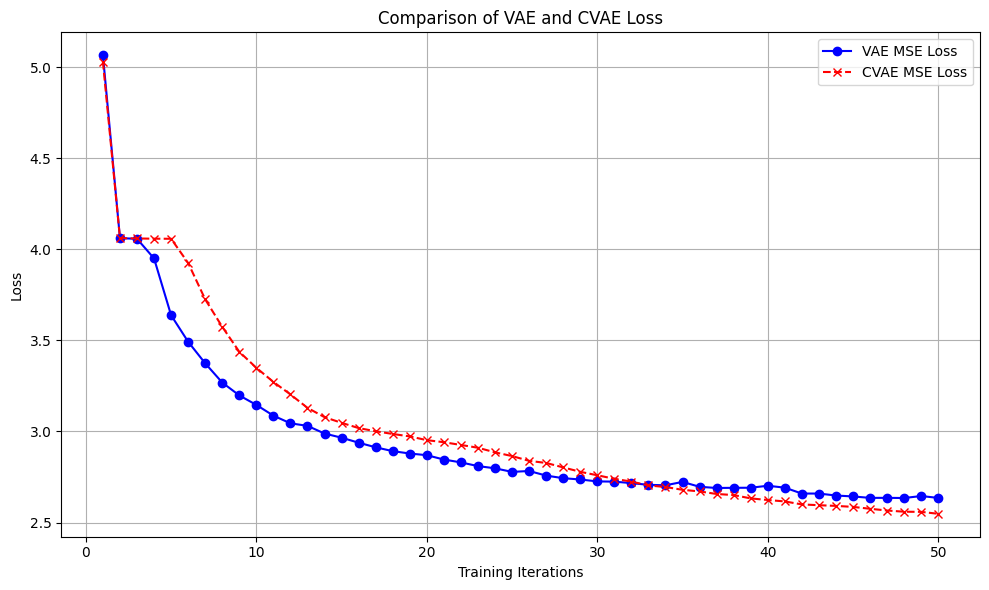

In [13]:
import matplotlib.pyplot as plt

# Assuming you have two lists of loss values: vae_mse_loss and cvae_mse_loss
# You should have these lists populated with the corresponding loss values during training.

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(cvae_MSE_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_MSE_Loss, label='VAE MSE Loss', marker='o', linestyle='-', color='b')
plt.plot(iterations, cvae_MSE_Loss, label='CVAE MSE Loss', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Comparison of VAE and CVAE Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

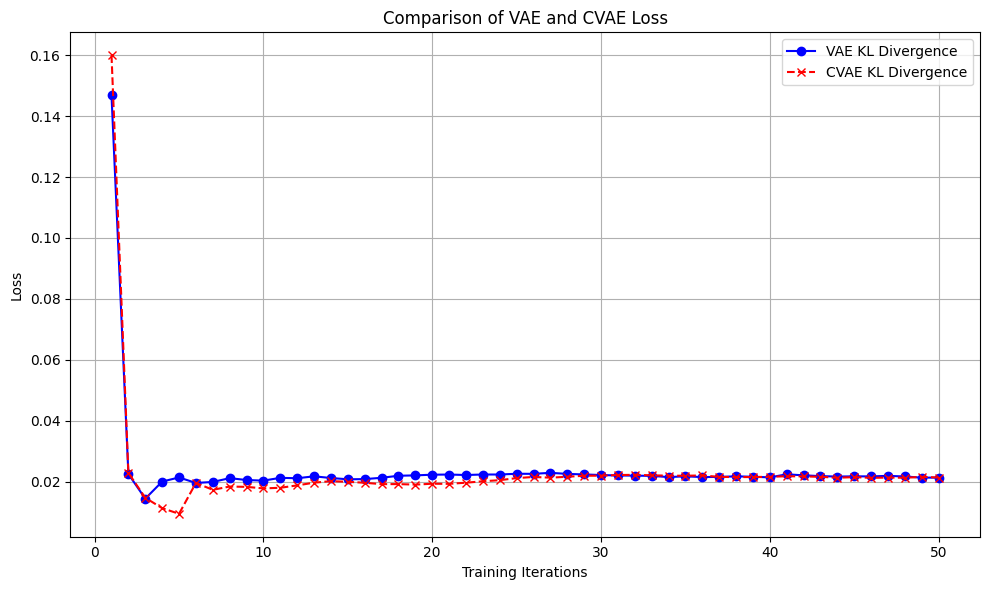

In [14]:
import matplotlib.pyplot as plt

# Assuming you have two lists of loss values: vae_mse_loss and cvae_mse_loss
# You should have these lists populated with the corresponding loss values during training.

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(cvae_KL_Loss) + 1)
cvae_KL_Loss
# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, vae_KL_Loss, label='VAE KL Divergence', marker='o', linestyle='-', color='b')
plt.plot(iterations, cvae_KL_Loss, label='CVAE KL Divergence', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Comparison of VAE and CVAE Loss')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation and Plotting

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(decode_function, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])

            x_hat = decode_function(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def plot_c_reconstructed(decode_function, c, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])
            x_hat = decode_function(z,c,i)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def imshow(img):
    npimg = img.numpy()
    npimg = np.clip(npimg/255.,0,1) #we need to clip here to avoid bad image values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Test Data for cVAE

d) Using k=2, plot the latent space, displaying data points at their embedded points. Qualitatively compare this to the latent space produced by the regular VAE, and discuss changes.

torch.Size([10, 1, 28, 28])


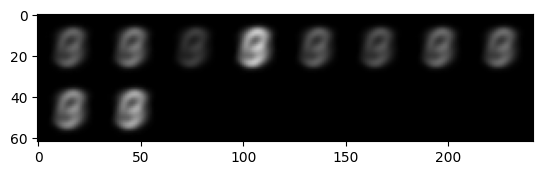

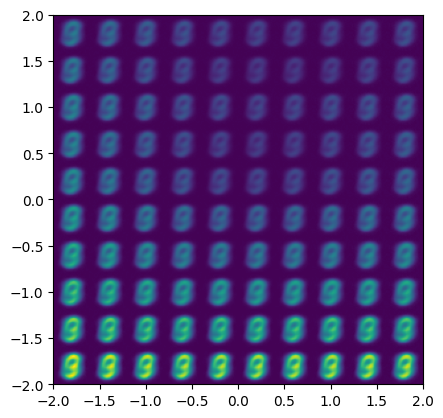

torch.Size([10, 1, 28, 28])


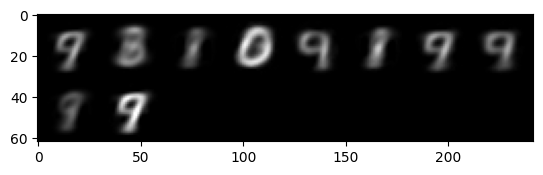

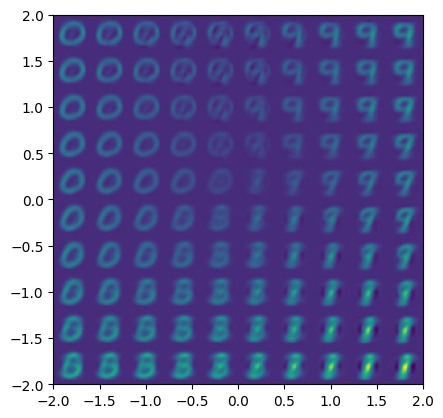

torch.Size([10, 1, 28, 28])


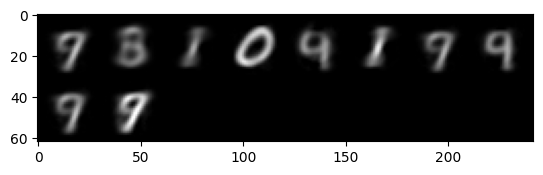

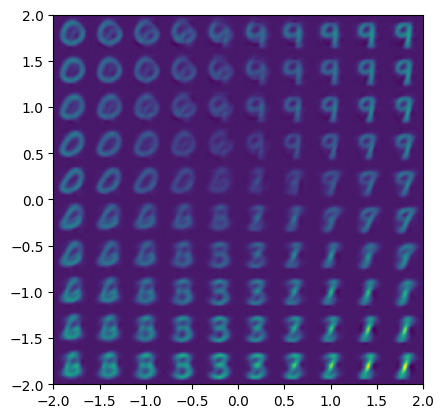

torch.Size([10, 1, 28, 28])


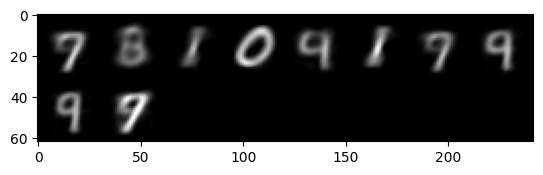

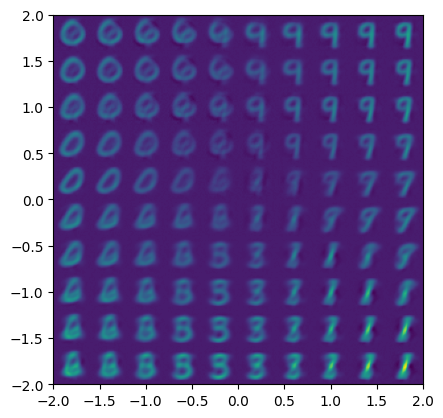

torch.Size([10, 1, 28, 28])


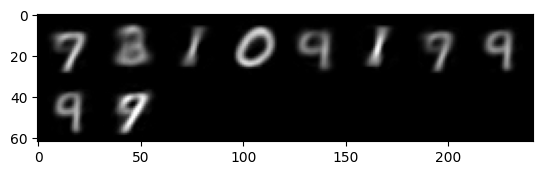

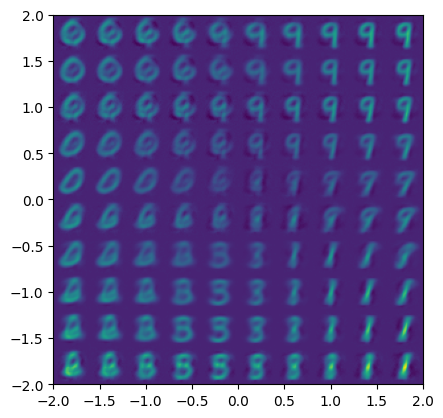

torch.Size([10, 1, 28, 28])


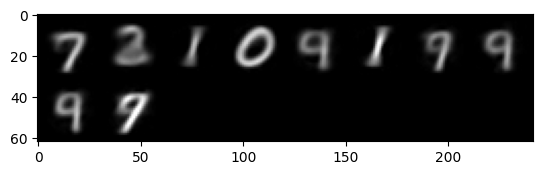

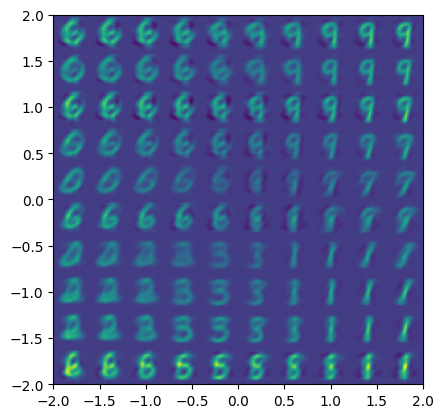

torch.Size([10, 1, 28, 28])


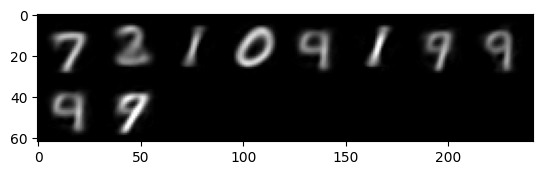

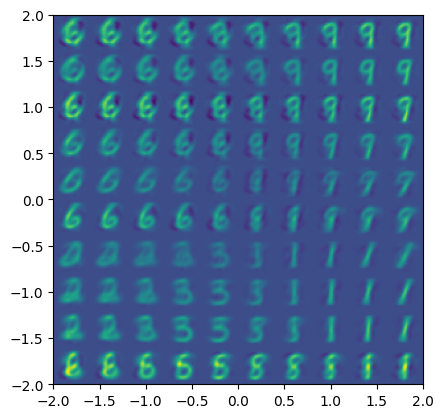

torch.Size([10, 1, 28, 28])


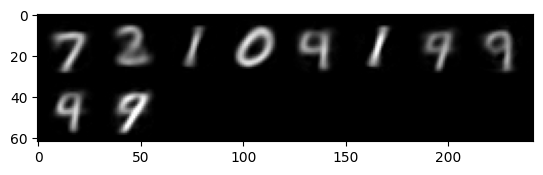

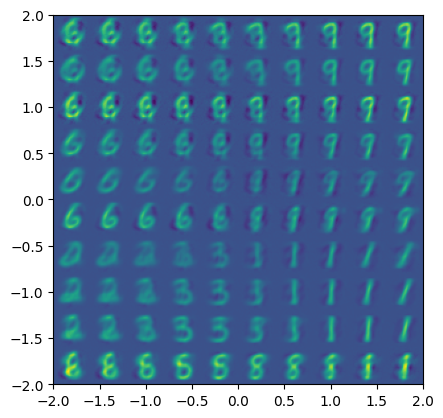

torch.Size([10, 1, 28, 28])


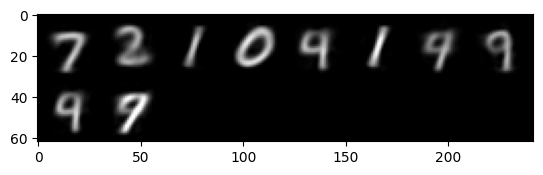

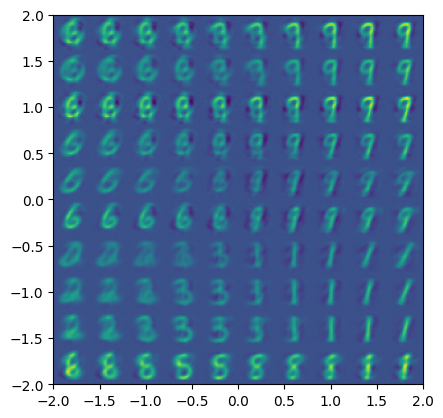

torch.Size([10, 1, 28, 28])


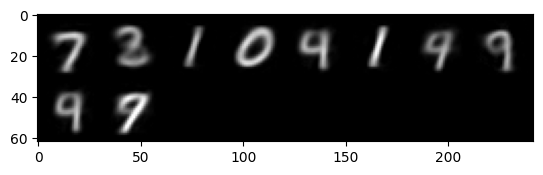

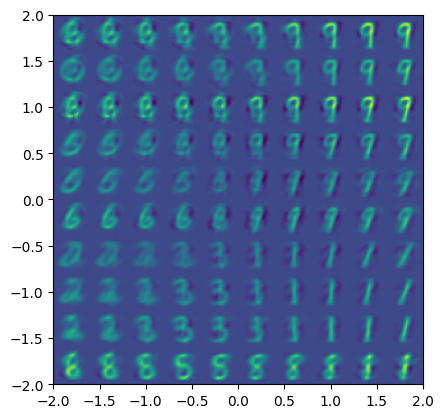

In [10]:
saved_params_path = "./saved_params_cvae"
cvae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

#labels = torch.Tensor([9, 3, 7, 8, 7, 1, 7, 6, 4, 8])
for epoch in range(4,50,5):
    cvae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = cvae_instance.forward(images_in, labels)

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)

    imshow(image_outputs)

    z = mean_z + torch.randn_like(mean_z) * (log_var_z.exp().sqrt())

    # I don't see the point of plotting reconstructed with cvae since given z on reconstructed fucntion,
    # we don't know how they are related to our labels. For training, we do know that what z value represents
    # and we can match them to labels. However, in this scenario in reconstructed function, we do not know
    # where z values came from.
    plot_c_reconstructed(
        cvae_instance.decode, labels
    )
    plt.show()

# Test Data for VAE

4
torch.Size([10, 1, 28, 28])


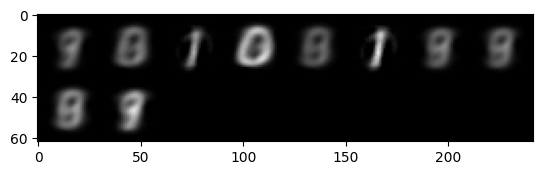

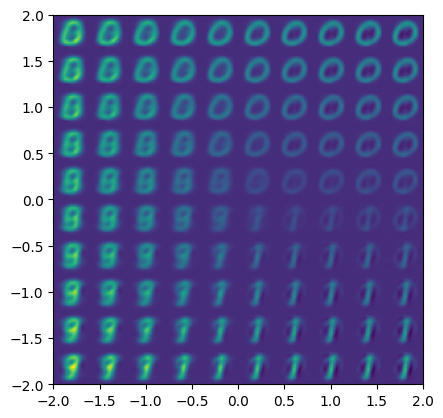

9
torch.Size([10, 1, 28, 28])


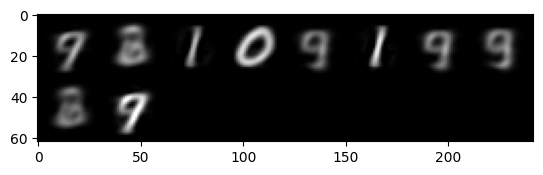

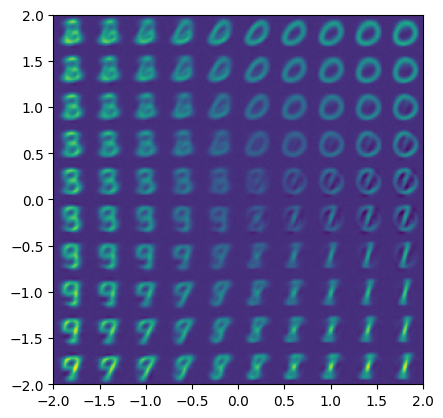

14
torch.Size([10, 1, 28, 28])


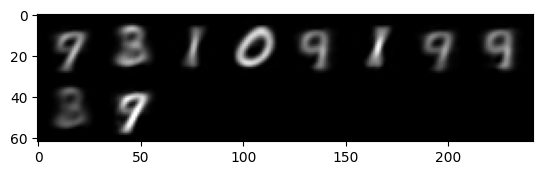

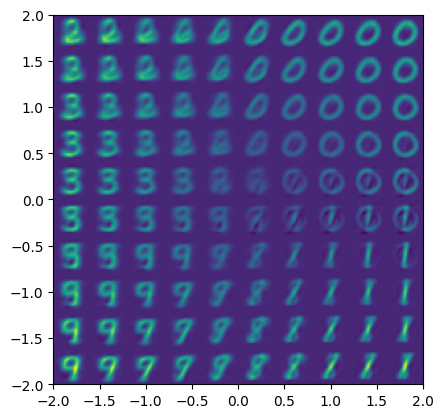

19
torch.Size([10, 1, 28, 28])


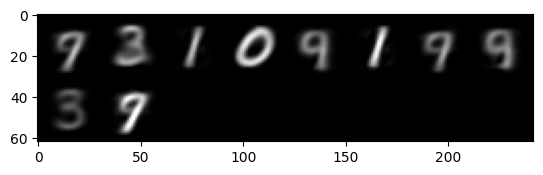

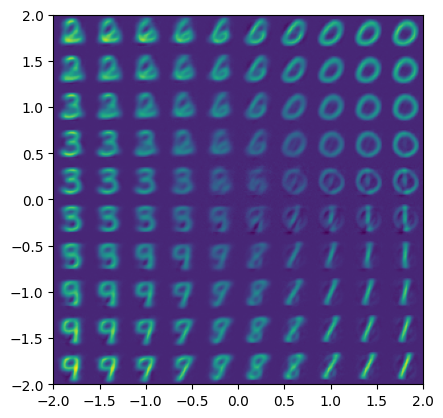

24
torch.Size([10, 1, 28, 28])


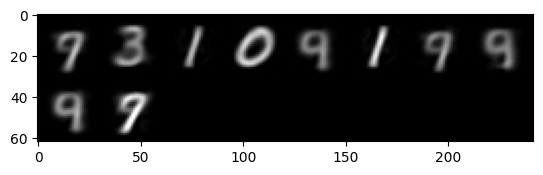

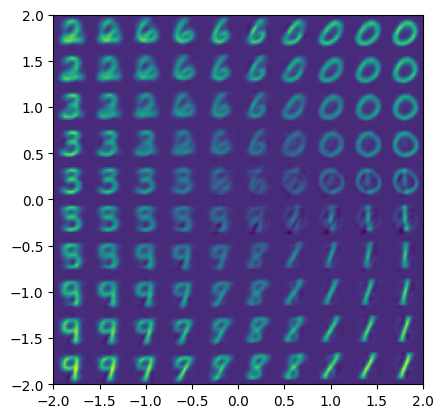

29
torch.Size([10, 1, 28, 28])


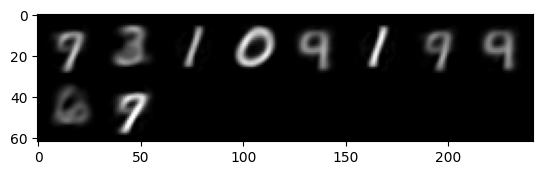

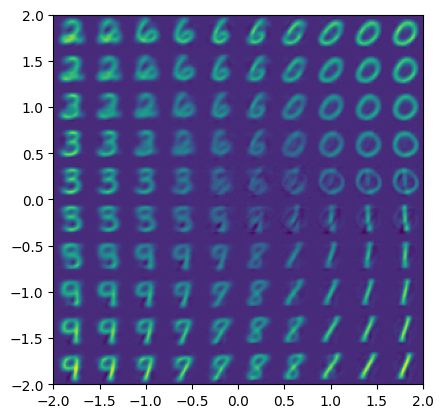

34
torch.Size([10, 1, 28, 28])


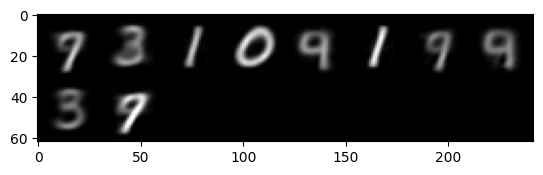

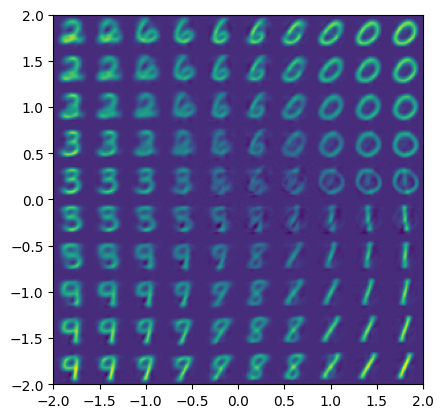

39
torch.Size([10, 1, 28, 28])


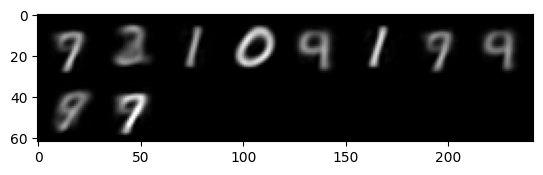

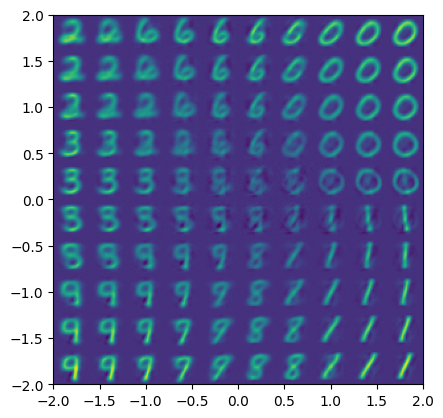

44
torch.Size([10, 1, 28, 28])


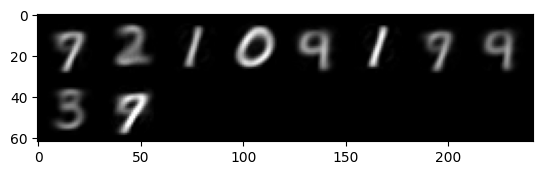

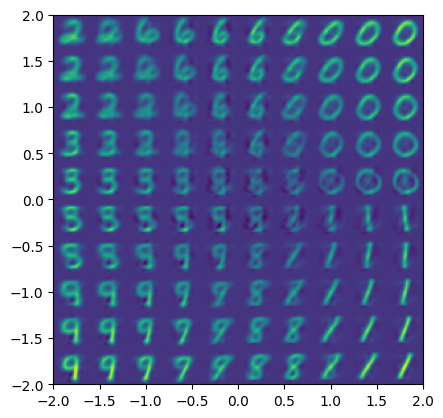

49
torch.Size([10, 1, 28, 28])


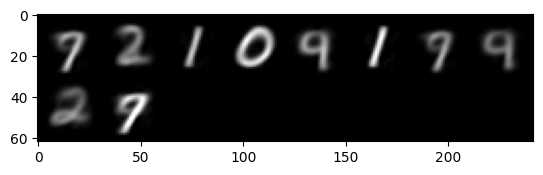

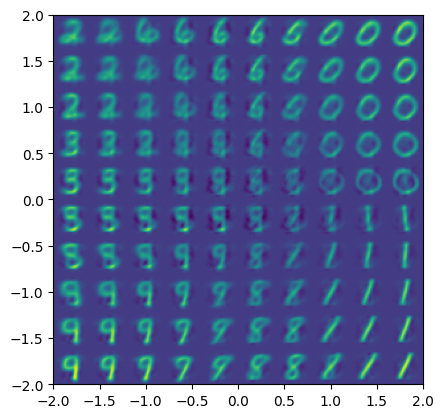

In [12]:
saved_params_path = "./saved_params_vae"
vae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

for epoch in range(4,50,5):
    print(epoch)
    vae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = vae_instance.forward_train(images_in)

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)

    imshow(image_outputs)

    plot_reconstructed(
        vae_instance.decode
    )
    plt.show()

e) Manipulate the c variable; using each of the first 10 datapoints in the test dataset as an input, change c to each of the classes and plot the results.

#2. Two Step

Consider the standard VAE with pattern

$x \rightarrow_{q(z|x)} z \rightarrow_{p(x|z)} \rightarrow \hat{x}$.

and with Gaussian encoers $q(z|x)$ using deterministic $f_\mu(x)$ and $f_\sigma(x)$, Gaussian priors for z, and deterministic decoder $g(z)$. We can re-index the variables $\{x,z,\hat{x}\}$ to $\{x_0,z_0,x_1\}$, and then extend this pattern: $x_0 \rightarrow_{q(z|x)} z_0 \rightarrow_{p(x|z)} \rightarrow x_1$.

a) Using the VAE, investigate empirically whether $z_0 $ and $z_1$ are similar for real data inputs $x_0$ from MNIST. Support your conclusion with plots/code.



b) Describe the distribution $q(z_0,z_1|x_0);$ is it Gaussian? Why or why not?

$P(z_0,z_1|x_0) = P(z_0|x_0)P(z_1|z_0,x_0)$.

We definitely know $P(z_0|x_0)$ is Gaussian, then if $P(z_1|z_0,x_0)$ is also Gaussian, $q(z_0,z_1|x_0)$ is Gaussian.

$P(z_1|z_0,x_0) = P(z_1|z_0)$ by using conditional independence. We can use conditional independence by looking at structure of our VAE $(x_0 \rightarrow z_0 \rightarrow x_1 \rightarrow z_1).$ Since $z_0$ and $z_1$ are caused from $x_0$, we can think $P(z_1|z_0,x_1)$ is conditionally independent.

Then, $P(z_1|z_0)$ is definitely also a Gaussian since our decoder is deterministic.

Therefore, $q(z_0,z_1|x_0)$ is a Gaussian.

c) Is regularizing $q(z_0,z_1|x_0)$ in the same way as we regularized $q(z_0|x_0)$, reasonable for making $z_0$ and $z_1$ similar?




d) Suppose instead we added a regularization term $||z_0 - z_1||^2_2$ to the loss function. What are we intuitively asking of our model? Is there an associated probability model with this ask?

e) Provide another regularization option besides the term introduced in part d), and argue for its correctness as a good regularization term.

# 3 Causing Collapses and Overfits

a) Describe qualitatively the posterior collapse phenomenon and why it's a problem

b) Describe ways to diagnose posterior collapse

c) Explain a possible cause efor your instructors' particular posterior collapse, explaining how the modification to the code induces such a collapse

d) Another error mode of the VAE is overfitting. Describe the overfit phenomena in the context of auto-encoder

e) Is it possible to both overfit and have posterior collapse?

2.5991649627685547

In [ ]:
first_b = next(iter(test_loader))

In [ ]:
cvae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

In [ ]:
labels.shape
labels = labels.view(labels.shape[0],1)
#c_z = torch.concat([z,labels], dim=1)

In [ ]:
c = labels.view(labels.shape[0],1)
c = NormalizeTensor(c)
c_z = torch.cat([z,c], dim=1)

In [ ]:
c_z.shape

torch.Size([1024, 6])

In [ ]:
labels = F.one_hot(labels)
    #c_z = torch.concat([z,c], dim=1)

In [ ]:
labels.shape

torch.Size([1024, 10])

In [ ]:
a = []

In [ ]:
a.append(1.873)

In [ ]:
a

[1, 2, 1.873]

In [ ]:
pwd

'/content'

In [ ]:
ls

sample_data/
